# Knowledge Distillation with Metric Checkpointing, LR Scheduling, and Drive Mounting

This notebook demonstrates knowledge distillation from a ResNet50 teacher to a ResNet18 student using both soft target and attention transfer methods. Enhancements include:

- **Metric Checkpointing:** Training/validation metrics are saved to a JSON file, ensuring that when resuming training (e.g. in Colab), previous metrics are retained for plotting.
- **Learning Rate Schedulers:** LR schedulers (using StepLR) have been added to both teacher and student training loops to improve convergence.
- **Mixed Precision Compatibility:** Mixed precision training is enabled via AMP and is applied consistently across all losses including the attention transfer loss (which uses cosine similarity).
- **Google Drive Integration:** The notebook mounts your Google Drive to persist models, checkpoints, metrics, results, and plots.

## Citations

> - Hinton, G., Vinyals, O., & Dean, J. (2015). *Distilling the Knowledge in a Neural Network.*
> - Zagoruyko, S., & Komodakis, N. (2017). *Paying More Attention to Attention: Improving the Performance of Convolutional Neural Networks via Attention Transfer.*

In [ ]:
# Mount Google Drive (for Colab users)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = '/content/drive/MyDrive/KnowledgeDistillation/Final_Scalable_Cifar10_KD'
except ImportError:
    BASE_DIR = '.'

# Create necessary directories on your drive
import os
MODEL_DIR = os.path.join(BASE_DIR, 'models')
RESULTS_DIR = os.path.join(BASE_DIR, 'code')
PLOT_DIR = os.path.join(BASE_DIR, 'plots')
for d in [MODEL_DIR, RESULTS_DIR, PLOT_DIR]:
    os.makedirs(d, exist_ok=True)

Mounted at /content/drive


In [ ]:
import os
import time
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from tqdm import tqdm

# ========== Configuration ==========
CONFIG = {
    'dataset': 'cifar10',
    'num_runs': 1,
    'epochs': {
        'teacher': 30,
        'student': 20,
        'tuning': 5
    },
    'hparams': {
        'soft': {
            'temperatures': [3, 5, 7],
            'alphas': [0.3, 0.5, 0.7]
        },
        'attention': {
            'alphas': [0.3, 0.5, 0.7]
        }
    },
    'early_stopping': {
        'patience': 5,
        'delta': 0.002
    },
    'model_dir': MODEL_DIR,
    'results_dir': RESULTS_DIR,
    'plot_dir': PLOT_DIR,
    'metrics_file': os.path.join(MODEL_DIR, 'metrics.json'),
    'seed': 42,
    'batch_size': 128,
    'num_workers': 4,
    'use_amp': True,
    'checkpoint_interval': 1
}

# Global metrics storage
METRICS = {
    'teacher': {'train_loss': [], 'val_acc': []},
    'student_soft': {'train_loss': [], 'val_acc': []},
    'student_attention': {'train_loss': [], 'val_acc': [], 'attention_similarity': []},
    'best_params': {  # Add this section
        'soft': None,
        'attention': None
    },
    'compression_ratio': None,
    'inference_speed': {'teacher': None, 'student_soft': None, 'student_attention': None},
    'test_accuracies': {'teacher': None, 'student_soft': None, 'student_attention': None}
}

# Set random seeds
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

# ========== Dataset Config ==========
DATASET_CONFIG = {
    'cifar10': {
        'num_classes': 10,
        'dataset_class': datasets.CIFAR10,
        'transform': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ===== Metric Checkpointing Functions =====
def save_metrics(metrics, filename):
    with open(filename, 'w') as f:
        json.dump(metrics, f)

def load_metrics(filename):
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return json.load(f)
    return None

# Load previously saved metrics if available
saved_metrics = load_metrics(CONFIG['metrics_file'])
if saved_metrics is not None:
    METRICS = saved_metrics
    print("Loaded saved metrics.")
else:
    print("No saved metrics found; starting fresh.")

Loaded saved metrics.


In [ ]:
# ========== Model Architecture ==========
class AttentionWrapper(nn.Module):
    def __init__(self, base_model, num_classes, pretrained=True):
        super().__init__()
        # Use "model" to match checkpoint keys
        if base_model == 'resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        else:
            self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)

        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

        self.attention_maps = {}
        self._register_hooks()

    def _register_hooks(self):
        def hook_fn(name):
            def hook(_, __, output):
                self.attention_maps[name] = output.detach()
            return hook
        self.model.layer2.register_forward_hook(hook_fn('layer2'))
        self.model.layer4.register_forward_hook(hook_fn('layer4'))

    def forward(self, x):
        self.attention_maps = {}
        return self.model(x)

    def get_attention_maps(self):
        return [self.attention_maps.get('layer2'),
                self.attention_maps.get('layer4')]

# Helper: Load checkpoint if exists
def load_checkpoint(model, optimizer, filename):
    if os.path.exists(filename):
        print(f"Loading checkpoint from {filename}")
        checkpoint = torch.load(filename, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val = checkpoint.get('best_val', 0)
        # Return adaptation layers if present
        adaptation = checkpoint.get('adaptation_layers', None)
        return (
            checkpoint['epoch'] + 1,
            checkpoint.get('best_val', 0),
            adaptation
        )
    return 0, 0

# Save checkpoint
def save_checkpoint(model, optimizer, epoch, best_val, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val': best_val
    }, filename)

In [ ]:
# ========== Training Utilities ==========
def evaluate_model(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def measure_inference_speed(model, loader, device):
    model.eval()
    start_time = time.time()
    total_samples = 0
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            _ = model(inputs)
            total_samples += inputs.size(0)
    elapsed = time.time() - start_time
    return total_samples / elapsed

def calculate_attention_similarity(teacher, student, loader, device, adaptation_layers=None, use_cosine=True):
    teacher.eval()
    student.eval()
    total_similarity = 0
    total_batches = 0

    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)

            # Get teacher features
            _ = teacher(inputs)
            t_atts = teacher.get_attention_maps()

            # Get student features
            _ = student(inputs)
            s_atts = student.get_attention_maps()

            batch_sim = 0
            count = 0

            for t_att, s_att, adapt_layer in zip(t_atts, s_atts, adaptation_layers):
                if t_att is None or s_att is None:
                    continue

                # Apply adaptation layers if provided
                if adapt_layer is not None:
                    s_att = adapt_layer(s_att)

                # Handle spatial mismatch
                if t_att.shape[-2:] != s_att.shape[-2:]:
                    t_att = F.adaptive_avg_pool2d(t_att, s_att.shape[-2:])

                t_flat = t_att.view(t_att.size(0), -1)
                s_flat = s_att.view(s_att.size(0), -1)

                if use_cosine:
                    cos_sim = F.cosine_similarity(t_flat, s_flat, dim=1)
                    batch_sim += cos_sim.mean().item()
                else:
                    batch_sim += (torch.norm(t_flat - s_flat, p=2).item() / t_att.size(0))
                count += 1

            if count > 0:
                total_similarity += batch_sim / count
                total_batches += 1

    return total_similarity / total_batches if total_batches > 0 else 0

# ===== Teacher Training =====
def train_teacher():
    config = DATASET_CONFIG['cifar10']
    train_set = config['dataset_class'](root='./data', train=True, download=True, transform=config['transform'])
    test_set = config['dataset_class'](root='./data', train=False, download=True, transform=config['transform'])
    train_indices, val_indices = train_test_split(range(len(train_set)), test_size=0.2, random_state=CONFIG['seed'])
    train_loader = DataLoader(Subset(train_set, train_indices), batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'])
    val_loader = DataLoader(Subset(train_set, val_indices), batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])
    test_loader = DataLoader(test_set, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])

    teacher = AttentionWrapper('resnet50', config['num_classes'], pretrained=True)
    teacher.to(device)
    optimizer = optim.AdamW(teacher.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    criterion = nn.CrossEntropyLoss()

    cp_path = os.path.join(CONFIG['model_dir'], 'teacher_checkpoint.pth')
    start_epoch, best_val = load_checkpoint(teacher, optimizer, cp_path)
    scaler = torch.cuda.amp.GradScaler(enabled=CONFIG['use_amp'])



    # Early stopping variables
    patience = CONFIG['early_stopping']['patience']
    delta = CONFIG['early_stopping']['delta']
    patience_counter = 0

    # Check for existing best model
    best_model_path = os.path.join(CONFIG['model_dir'], 'teacher_best.pth')
    if os.path.exists(best_model_path):
        print("Loading existing best teacher model")
        teacher.load_state_dict(torch.load(best_model_path))
        test_acc = evaluate_model(teacher, test_loader, device)
        METRICS['test_accuracies']['teacher'] = test_acc
        return teacher, test_acc, val_loader, test_loader

    for epoch in range(start_epoch, CONFIG['epochs']['teacher']):
        teacher.train()
        epoch_loss = 0
        for inputs, labels in tqdm(train_loader, desc=f'Teacher Epoch {epoch+1}'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=CONFIG['use_amp']):
                outputs = teacher(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()

        scheduler.step()
        val_acc = evaluate_model(teacher, val_loader, device)
        METRICS['teacher']['train_loss'].append(epoch_loss/len(train_loader))
        METRICS['teacher']['val_acc'].append(val_acc)
        print(f"Teacher Epoch {epoch+1}: Loss={epoch_loss/len(train_loader):.4f}, Val Acc={val_acc:.4f}")

        # Save checkpoint and metrics
        if (epoch + 1) % CONFIG['checkpoint_interval'] == 0:
            save_checkpoint(teacher, optimizer, epoch, val_acc, cp_path)
            save_metrics(METRICS, CONFIG['metrics_file'])

        # Check for improvement, update early stopping counter
        if val_acc > best_val + delta:
            best_val = val_acc
            patience_counter = 0
            torch.save(teacher.state_dict(), os.path.join(CONFIG['model_dir'], 'teacher_best.pth'))
        else:
            patience_counter += 1
            print(f"No significant improvement for {patience_counter} epoch(s).")
            if patience_counter >= patience:
                print("Early stopping triggered for teacher training.")
                break

    test_acc = evaluate_model(teacher, test_loader, device)
    print(f"\nTeacher Final Test Accuracy: {test_acc:.4f}")
    METRICS['test_accuracies']['teacher'] = test_acc
    return teacher, test_acc, val_loader, test_loader


# ===== Distillation Methods =====
class DistillationTrainer:
    def __init__(self, teacher, device):
        self.teacher = teacher
        self.device = device
        self.config = DATASET_CONFIG['cifar10']
        self.load_data()

    def load_data(self):
        train_set = self.config['dataset_class'](root='./data', train=True, download=True, transform=self.config['transform'])
        test_set = self.config['dataset_class'](root='./data', train=False, transform=self.config['transform'])
        train_indices, val_indices = train_test_split(range(len(train_set)), test_size=0.2, random_state=CONFIG['seed'])
        self.train_loader = DataLoader(Subset(train_set, train_indices), batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'])
        self.val_loader = DataLoader(Subset(train_set, val_indices), batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])
        self.test_loader = DataLoader(test_set, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])

    # In tune_soft_target():
    def tune_soft_target(self):
        if METRICS['best_params']['soft'] is not None:
            print("Using existing soft params from metrics that was already saved after tuning", METRICS['best_params']['soft'])
            return METRICS['best_params']['soft']
        best_acc = 0
        best_params = {}

        for alpha in CONFIG['hparams']['soft']['alphas']:
            for temp in CONFIG['hparams']['soft']['temperatures']:
                print(f"\nTuning Soft Targets: α={alpha}, T={temp}")

                # Unique checkpoint path for each combination
                cp_path = os.path.join(
                    CONFIG['model_dir'],
                    f'student_soft_a{alpha}_t{temp}_checkpoint.pth'  # <-- Unique filename
                )

                student = AttentionWrapper('resnet18', self.config['num_classes'], pretrained=False)
                student.to(self.device)
                optimizer = optim.AdamW(student.parameters(), lr=1e-3)

                # Pass the unique checkpoint path to train_soft_target
                val_acc = self.train_soft_target(
                    student, optimizer, alpha, temp,
                    cp_path=cp_path,  # <-- Add this argument
                    tuning=True,
                    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
                )

                if val_acc > best_acc:
                    best_acc = val_acc
                    best_params = {'alpha': alpha, 'temperature': temp}

                # Clean up temporary checkpoint after tuning
                if os.path.exists(cp_path):
                    os.remove(cp_path)

        print(f"\nBest Soft Params: {best_params}")
        METRICS['best_params']['soft'] = best_params  # <-- ADD THIS
        return best_params


    def tune_attention_transfer(self):
        if METRICS['best_params']['attention'] is not None:
            print("Using existing attention params from metrics that was already saved after tuning: ", METRICS['best_params']['attention'])
            return METRICS['best_params']['attention']
        best_acc = 0
        best_params = {}

        # Clean up old attention checkpoints
        for f in os.listdir(CONFIG['model_dir']):
            if f.startswith('student_attention_a') and f.endswith('_checkpoint.pth'):
                os.remove(os.path.join(CONFIG['model_dir'], f))

        for alpha in CONFIG['hparams']['attention']['alphas']:
            print(f"\nTuning Attention Transfer: α={alpha}")

            # Unique checkpoint path per alpha
            cp_path = os.path.join(
                CONFIG['model_dir'],
                f'student_attention_a{alpha}_checkpoint.pth'  # Unique filename
            )

            student = AttentionWrapper('resnet18', self.config['num_classes'], pretrained=False)
            student.to(self.device)
            optimizer = optim.AdamW(student.parameters(), lr=1e-3)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

            # Pass the unique checkpoint path
            val_acc = self.train_attention_transfer(
                student, optimizer, alpha,
                cp_path=cp_path,  # <-- Add this argument
                tuning=True,
                scheduler=scheduler
            )

            if val_acc > best_acc:
                best_acc = val_acc
                best_params = {'alpha': alpha}

            # Clean up temporary checkpoint
            if os.path.exists(cp_path):
                os.remove(cp_path)
        print(f"\nBest Attention Params: {best_params}")
        METRICS['best_params']['attention'] = best_params  # <-- ADD THIS
        return best_params


    def train_soft_target(self, student, optimizer, alpha, temperature,cp_path, tuning=False, scheduler=None):
        student.to(self.device)
        self.teacher.to(self.device)
        ce_loss = nn.CrossEntropyLoss()
        kl_loss = nn.KLDivLoss(reduction='batchmean')
        scaler = torch.cuda.amp.GradScaler(enabled=CONFIG['use_amp'])
        best_acc = 0
        epochs = CONFIG['epochs']['tuning'] if tuning else CONFIG['epochs']['student']
        start_epoch, _ = load_checkpoint(student, optimizer, cp_path)


        patience = CONFIG['early_stopping']['patience']
        delta = CONFIG['early_stopping']['delta']
        patience_counter = 0

        for epoch in range(start_epoch, epochs):
            student.train()
            epoch_loss = 0
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                with torch.no_grad():
                    teacher_logits = self.teacher(inputs)
                optimizer.zero_grad()
                with torch.cuda.amp.autocast(enabled=CONFIG['use_amp']):
                    student_logits = student(inputs)
                    task_loss = ce_loss(student_logits, labels)
                    soft_loss = kl_loss(
                        torch.log_softmax(student_logits/temperature, dim=1),
                        torch.softmax(teacher_logits/temperature, dim=1)
                    ) * (temperature ** 2)
                    loss = (1 - alpha) * task_loss + alpha * soft_loss
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                epoch_loss += loss.item()
            if scheduler is not None:
                scheduler.step()
            val_acc = evaluate_model(student, self.val_loader, self.device)
            if not tuning:  # ONLY STORE METRICS FOR FINAL TRAINING
                METRICS['student_soft']['train_loss'].append(epoch_loss/len(self.train_loader))
                METRICS['student_soft']['val_acc'].append(val_acc)
            print(f"Soft Target Epoch {epoch+1}: Loss={epoch_loss/len(self.train_loader):.4f}, Val Acc={val_acc:.4f}")
            if (epoch+1) % CONFIG['checkpoint_interval'] == 0:
                save_checkpoint(student, optimizer, epoch, val_acc, cp_path)
                save_metrics(METRICS, CONFIG['metrics_file'])
            if val_acc > best_acc + delta:
                best_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1
                print(f"No significant improvement for {patience_counter} epoch(s).")
                if patience_counter >= patience:
                    print("Early stopping triggered for soft target training.")
                    break
        return best_acc


    def train_attention_transfer(self, student, optimizer, alpha, cp_path, tuning=False, scheduler=None):
        student.to(self.device)
        self.teacher.to(self.device)

        # Add adaptation layers for dimension matching
        adaptation_layers = nn.ModuleList()
        with torch.no_grad():
            # Get sample attention shapes
            dummy_input = torch.randn(2, 3, 224, 224).to(self.device)
            _ = self.teacher(dummy_input)
            teacher_atts = self.teacher.get_attention_maps()
            _ = student(dummy_input)
            student_atts = student.get_attention_maps()

            for t_att, s_att in zip(teacher_atts, student_atts):
                if t_att is None or s_att is None:
                    continue
                # Create layer to adapt student channels to teacher
                in_channels = s_att.shape[1]
                out_channels = t_att.shape[1]
                adaptation_layers.append(
                    nn.Conv2d(in_channels, out_channels, kernel_size=1).to(self.device))

        ce_loss = nn.CrossEntropyLoss()
        scaler = torch.cuda.amp.GradScaler(enabled=CONFIG['use_amp'])
        best_acc = 0
        epochs = CONFIG['epochs']['tuning'] if tuning else CONFIG['epochs']['student']

        # Load checkpoint including adaptation layers
        if os.path.exists(cp_path):
            checkpoint = torch.load(cp_path)
            student.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            adaptation_layers.load_state_dict(checkpoint['adaptation_layers'])
            start_epoch = checkpoint['epoch'] + 1
            best_acc = checkpoint.get('best_acc', 0)
        else:
            start_epoch = 0

        patience = CONFIG['early_stopping']['patience']
        delta = CONFIG['early_stopping']['delta']
        patience_counter = 0

        for epoch in range(start_epoch, epochs):
            student.train()
            adaptation_layers.train()
            epoch_loss = 0

            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                with torch.no_grad():
                    _ = self.teacher(inputs)
                    teacher_atts = self.teacher.get_attention_maps()

                optimizer.zero_grad()
                with torch.cuda.amp.autocast(enabled=CONFIG['use_amp']):
                    _ = student(inputs)
                    student_atts = student.get_attention_maps()

                    task_loss = ce_loss(student(inputs), labels)
                    att_loss = 0
                    count = 0

                    for t_att, s_att, adapt_layer in zip(teacher_atts, student_atts, adaptation_layers):
                        if t_att is None or s_att is None:
                            continue

                        # Adapt student features to teacher dimensions
                        s_att = adapt_layer(s_att)

                        # Spatial alignment
                        if t_att.shape[-2:] != s_att.shape[-2:]:
                            t_att = F.adaptive_avg_pool2d(t_att, s_att.shape[-2:])

                        # Flatten and normalize
                        t_flat = F.normalize(t_att.view(t_att.size(0), -1))
                        s_flat = F.normalize(s_att.view(s_att.size(0), -1))

                        # Cosine similarity
                        cos_sim = (t_flat * s_flat).sum(dim=1)
                        att_loss += (1 - cos_sim).mean()
                        count += 1

                    if count > 0:
                        att_loss = att_loss / count
                    else:
                        att_loss = 0

                    loss = (1 - alpha) * task_loss + alpha * att_loss

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                epoch_loss += loss.item()

            if scheduler is not None:
                scheduler.step()

            # Validation
            val_acc = evaluate_model(student, self.val_loader, self.device)
            sim = calculate_attention_similarity(self.teacher, student,
                                        self.val_loader, self.device,
                                        adaptation_layers=adaptation_layers)

            if not tuning:
                METRICS['student_attention']['train_loss'].append(epoch_loss/len(self.train_loader))
                METRICS['student_attention']['val_acc'].append(val_acc)
                METRICS['student_attention']['attention_similarity'].append(sim)

            print(f"Attention Transfer Epoch {epoch+1}: "
                  f"Loss={epoch_loss/len(self.train_loader):.4f}, "
                  f"Val Acc={val_acc:.4f}, Attn Sim={sim:.4f}")

            # Save checkpoint with adaptation layers
            if (epoch+1) % CONFIG['checkpoint_interval'] == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': student.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'adaptation_layers': adaptation_layers.state_dict(),
                    'best_acc': best_acc,
                    'metrics': METRICS
                }, cp_path)
                save_metrics(METRICS, CONFIG['metrics_file'])

            # Early stopping
            if val_acc > best_acc + delta:
                best_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        return best_acc

In [ ]:
# Core Data Handling
import os
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
# Deep Learning
import torch
from torch.utils.data import DataLoader

# Type Hints (optional but recommended)
from typing import Dict, List, Optional, Tuple, Union

def set_style():
    """Custom styling for all plots with enhanced settings"""
    sns.set_style("whitegrid", {
        'axes.edgecolor': '0.2',
        'axes.linewidth': 0.8,
        'grid.color': '0.9',
        'grid.linestyle': '--',
        'grid.linewidth': 0.5
    })

    sns.set_palette("husl")
    plt.rcParams.update({
        # Figure
        "figure.figsize": (14, 8),
        "figure.dpi": 150,
        "figure.autolayout": True,
        "figure.titlesize": 18,

        # Font
        "font.family": "DejaVu Sans",
        "font.size": 12,
        "font.weight": "normal",

        # Axes
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "axes.titleweight": "bold",
        "axes.titlepad": 15,
        "axes.labelweight": "normal",
        "axes.spines.top": False,
        "axes.spines.right": False,

        # Ticks
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "xtick.major.size": 6,
        "ytick.major.size": 6,

        # Legend
        "legend.fontsize": 12,
        "legend.frameon": True,
        "legend.framealpha": 0.9,
        "legend.edgecolor": "0.2",

        # Lines
        "lines.linewidth": 2.5,
        "lines.markersize": 8,

        # Saving
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.2,
        "savefig.dpi": 300,
        "savefig.format": "png"
    })

    sns.set_context("notebook", rc={
        "lines.linewidth": 2.5,
        "patch.linewidth": 0.8,
        "grid.linewidth": 0.5
    })

def plot_comprehensive_results(metrics, teacher, soft_student, attention_student, dataloader, device):
    """Master function for all visualizations without redundancy"""
    set_style()

    # Create directory if not exists
    os.makedirs(CONFIG['plot_dir'], exist_ok=True)

    # 1. Training Curves (from enhanced version)
    plot_training_curves(metrics)

    # 2. Main Comparison Plot (optimized version)
    plot_metrics(teacher, soft_student, attention_student, metrics)

    # 3. Attention Maps (from current version with enhancements)
    plot_attention_maps(teacher, attention_student, dataloader, device)

    # 4. Print formatted results
    print_final_metrics(metrics, teacher, soft_student, attention_student)

def plot_training_curves(metrics):
    """Enhanced training curves with custom styling"""
    set_style()
    plt.figure(figsize=(16, 6))

    # Custom color palette
    colors = {
        'teacher': '#1f77b4',
        'soft_student': '#2ca02c',
        'attention_student': '#d62728'
    }

    # Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(metrics['teacher']['train_loss'],
             label=f'Teacher (Final: {metrics["teacher"]["train_loss"][-1]:.3f})',
             color=colors['teacher'],
             marker='o', markevery=5)
    plt.plot(metrics['student_soft']['train_loss'],
             label=f'Soft Student (Final: {metrics["student_soft"]["train_loss"][-1]:.3f})',
             color=colors['soft_student'],
             marker='s', markevery=5)
    plt.plot(metrics['student_attention']['train_loss'],
             label=f'Attention Student (Final: {metrics["student_attention"]["train_loss"][-1]:.3f})',
             color=colors['attention_student'],
             marker='^', markevery=5)

    plt.title('Training Loss Progression', pad=20)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(framealpha=0.9)
    plt.grid(True, alpha=0.3)

    # Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics['teacher']['val_acc'],
             label=f'Teacher (Max: {max(metrics["teacher"]["val_acc"]):.2%})',
             color=colors['teacher'],
             marker='o', markevery=5)
    plt.plot(metrics['student_soft']['val_acc'],
             label=f'Soft Student (Max: {max(metrics["student_soft"]["val_acc"]):.2%})',
             color=colors['soft_student'],
             marker='s', markevery=5)
    plt.plot(metrics['student_attention']['val_acc'],
             label=f'Attention Student (Max: {max(metrics["student_attention"]["val_acc"]):.2%})',
             color=colors['attention_student'],
             marker='^', markevery=5)

    plt.title('Validation Accuracy Progression', pad=20)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(framealpha=0.9)
    plt.grid(True, alpha=0.3)

    plt.suptitle('Model Training Dynamics', y=1.05, fontsize=18)
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['plot_dir'], 'training_curves.png'))
    plt.close()

def plot_metrics(teacher, soft_student, attention_student, metrics):
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 12), constrained_layout=True)
    colors = sns.color_palette("husl", 3)
    models = ['Teacher', 'Soft Student', 'Attention Student']

    # Calculate model sizes (number of parameters)
    sizes = [
        sum(p.numel() for p in teacher.parameters()),
        sum(p.numel() for p in soft_student.parameters()),
        sum(p.numel() for p in attention_student.parameters())
    ]

    # Accuracy Comparison
    plt.subplot(2, 2, 1)
    accs = [metrics['test_accuracies']['teacher'],
            metrics['test_accuracies']['student_soft'],
            metrics['test_accuracies']['student_attention']]
    bars = plt.bar(models, accs, color=colors)
    plt.title('Model Accuracy Comparison', fontsize=14, pad=20)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.ylim(min(accs) - 0.05, 1)  # Adjusted for better visualization
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,  # Adjusted placement
                 f'{height:.4f}',
                 ha='center', va='bottom', fontsize=11)

    # Inference Speed Comparison
    plt.subplot(2, 2, 2)
    fps = [round(metrics['inference_speed']['teacher'],1),
           round(metrics['inference_speed']['student_soft'],1),
           round(metrics['inference_speed']['student_attention'],1)]
    bars = plt.bar(models, fps, color=colors)
    plt.title('Inference Speed Comparison (Samples/Second)', fontsize=14, pad=20)
    plt.ylabel('Samples/Second', fontsize=12)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,  # Adjusted placement
                 f'{height:.1f}',
                 ha='center', va='bottom', fontsize=11)

    # Model Size Comparison (Log Scale)
    plt.subplot(2, 2, 3)
    plt.bar(models, sizes, color=colors)
    plt.yscale('log')
    plt.title('Model Size Comparison (Log Scale)', fontsize=14, pad=20)
    plt.ylabel('Number of Parameters', fontsize=12)
    for i, size in enumerate(sizes):
        plt.text(i, size * 1.1, f"{size/1e6:.1f}M",  # Adjusted to avoid overlap
                 ha='center', va='bottom', fontsize=11)

    # Accuracy vs Model Characteristics
    plt.subplot(2, 2, 4)
    plt.scatter(models, accs, s=[(s / max(sizes)) * 1000 for s in sizes], c=colors, alpha=0.8)  # Normalized size scaling
    plt.title('Accuracy vs Model Characteristics', fontsize=14, pad=20)
    plt.xlabel('Model Type', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.ylim(min(accs) - 0.05, 1)

    # Annotations
    for i, (x, y) in enumerate(zip(models, accs)):
        plt.text(x, y + 0.03, f"Size: {sizes[i]/1e6:.1f}M\nSpeed: {fps[i]:.1f}/s",
                 ha='center', va='bottom', fontsize=9)

    plt.savefig(f"{CONFIG['plot_dir']}/enhanced_metrics_comparison.png", dpi=300)
    plt.close()
    print(f"Metrics plot saved to {CONFIG['plot_dir']}/enhanced_metrics_comparison.png")


def plot_attention_maps(teacher, student, dataloader, device, num_examples=3):
    """Enhanced attention map visualization with professional styling and clear comparisons"""
    set_style()
    teacher.eval()
    student.eval()

    # Get sample batch
    images, _ = next(iter(dataloader))
    images = images[:num_examples].to(device)

    # Get attention maps
    with torch.no_grad():
        _ = teacher(images)
        _ = student(images)
        teacher_att = teacher.get_attention_maps()
        student_att = student.get_attention_maps()

    # Create individual plots for each layer
    for layer_idx, layer_name in [(0, 'Layer 2'), (1, 'Layer 4')]:
        fig = plt.figure(figsize=(15, 5*num_examples))
        gs = GridSpec(num_examples, 3, figure=fig,
                              width_ratios=[1, 1, 1],
                              height_ratios=[1]*num_examples,
                              wspace=0.1, hspace=0.3)

        plt.suptitle(f'Attention Map Comparison - {layer_name}\nTeacher vs Student',
                    y=1.02, fontsize=16, fontweight='bold')

        for example_idx in range(num_examples):
            # Original Image
            ax_img = fig.add_subplot(gs[example_idx, 0])
            img = denormalize_cifar(images[example_idx].cpu())
            ax_img.imshow(img)
            ax_img.set_title(f'Sample {example_idx+1}\nInput Image', fontsize=12)
            ax_img.axis('off')

            # Teacher Attention
            ax_teacher = fig.add_subplot(gs[example_idx, 1])
            t_att = process_attention(teacher_att[layer_idx][example_idx])
            im_teacher = ax_teacher.imshow(t_att, cmap='magma', alpha=0.9)
            ax_teacher.set_title('Teacher Attention', fontsize=12, pad=10)
            ax_teacher.axis('off')
            add_colorbar(fig, im_teacher, ax_teacher)

            # Student Attention
            ax_student = fig.add_subplot(gs[example_idx, 2])
            s_att = process_attention(student_att[layer_idx][example_idx])
            im_student = ax_student.imshow(s_att, cmap='magma', alpha=0.9)
            ax_student.set_title('Student Attention', fontsize=12, pad=10)
            ax_student.axis('off')
            add_colorbar(fig, im_student, ax_student)

            # Add similarity score
            similarity = cosine_similarity(t_att.flatten(), s_att.flatten())
            fig.text(0.95, 0.85 - (0.25 * example_idx),
                    f'Sample {example_idx+1} Similarity: {similarity:.2f}',
                    ha='right', va='center', fontsize=12,
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

        save_path = os.path.join(CONFIG['plot_dir'], f'attention_comparison_{layer_name.lower().replace(" ", "_")}.png')
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close()

# Helper functions
def denormalize_cifar(tensor):
    """Denormalize CIFAR-10 tensor for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = tensor.permute(1, 2, 0).numpy()
    img = img * std.numpy() + mean.numpy()
    return np.clip(img, 0, 1)

def process_attention(attention):
    """Process attention tensor for visualization"""
    att = attention.cpu().numpy()
    if att.ndim == 3:  # Handle multi-channel attention
        att = att.mean(0)  # Average across channels
    return (att - att.min()) / (att.max() - att.min())  # Normalize to [0,1]

def add_colorbar(fig, im, ax):
    """Add professional colorbar to an axis"""
    cax = fig.add_axes([ax.get_position().x1+0.01,
                      ax.get_position().y0,
                      0.02,
                      ax.get_position().height])
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=8)
    cbar.outline.set_visible(False)

def cosine_similarity(a, b):
    """Calculate cosine similarity between two flattened arrays"""
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def print_final_metrics(metrics, teacher, soft_student, attention_student):
    """Formatted console output that calculates model sizes directly"""
    # Calculate model sizes
    teacher_params = sum(p.numel() for p in teacher.parameters())
    soft_params = sum(p.numel() for p in soft_student.parameters())
    attn_params = sum(p.numel() for p in attention_student.parameters())

    print("\n=== FINAL MODEL PERFORMANCE ===")
    print(f"{'Model':<20} | {'Test Acc':<9} | {'Params':<12} | {'Speed':<15} | {'Compression'}")
    print("-" * 70)
    print(f"{'Teacher':<20} | {metrics['test_accuracies']['teacher']:.4f}    | "
          f"{teacher_params/1e6:.1f}M{'':<6} | "
          f"{metrics['inference_speed']['teacher']:.0f}/s{'':<6} | {'1.0x'}")

    print(f"{'Soft Student':<20} | {metrics['test_accuracies']['student_soft']:.4f}    | "
          f"{soft_params/1e6:.1f}M{'':<6} | "
          f"{metrics['inference_speed']['student_soft']:.0f}/s{'':<6} | "
          f"{metrics['compression_ratio']:.1f}x")

    print(f"{'Attention Student':<20} | {metrics['test_accuracies']['student_attention']:.4f}    | "
          f"{attn_params/1e6:.1f}M{'':<6} | "
          f"{metrics['inference_speed']['student_attention']:.0f}/s{'':<6} | "
          f"{metrics['compression_ratio']:.1f}x")

In [ ]:
# ========== Main Experiment ==========
def run_experiment():

    # Initialize test_loader outside conditional blocks
    config = DATASET_CONFIG['cifar10']
    test_set = config['dataset_class'](root='./data', train=False, download=True, transform=config['transform'])
    test_loader = DataLoader(test_set, batch_size=CONFIG['batch_size'], shuffle=False)

    best_teacher_path = os.path.join(CONFIG['model_dir'], 'teacher_best.pth')
    if os.path.exists(best_teacher_path):
        print("=== Loading Pre-trained Teacher ===")
        teacher = AttentionWrapper('resnet50', config['num_classes'], pretrained=False)
        teacher.load_state_dict(torch.load(best_teacher_path))
        teacher.to(device)
        print("\n=== Loaded Teacher model successfully ===")
        teacher_acc = evaluate_model(teacher, test_loader, device)
    else:
        print("=== Training New Teacher ===")
        teacher, teacher_acc, val_loader, test_loader = train_teacher()
        teacher_acc = evaluate_model(teacher, test_loader, device)


    METRICS['test_accuracies']['teacher'] = teacher_acc
    METRICS['inference_speed']['teacher'] = measure_inference_speed(teacher, test_loader, device)


    trainer = DistillationTrainer(teacher, device)

    soft_final_path = os.path.join(CONFIG['model_dir'], 'student_soft_final_checkpoint.pth')
    print("\n=== Tuning Soft Target Student ===")
    best_soft_params = trainer.tune_soft_target()
    save_metrics(METRICS, CONFIG['metrics_file'])

    # For soft student loading
    if os.path.exists(soft_final_path):
        print("\n=== Loading Pre-trained Soft Student ===")
        soft_student = AttentionWrapper('resnet18', DATASET_CONFIG['cifar10']['num_classes'], pretrained=False)
        checkpoint = torch.load(soft_final_path)  # Load full checkpoint
        soft_student.load_state_dict(checkpoint['model_state_dict'])  # Extract model weights

        soft_student.to(device)
        print("\n=== Loaded Soft Student model successfully ===")

        soft_acc = evaluate_model(soft_student, trainer.test_loader, device)
    else:
        print("\n=== Training Final Soft Target Student ===")
        best_soft_params = trainer.tune_soft_target()
        save_metrics(METRICS, CONFIG['metrics_file'])

        soft_student = AttentionWrapper('resnet18', DATASET_CONFIG['cifar10']['num_classes'], pretrained=False)
        soft_student.to(device)
        soft_optimizer = optim.AdamW(soft_student.parameters(), lr=1e-3)

        trainer.train_soft_target(
            student=soft_student,
            optimizer=soft_optimizer,
            alpha=best_soft_params['alpha'],
            temperature=best_soft_params['temperature'],
            cp_path=soft_final_path,  # <-- ADD THIS LINE
            tuning=False,
            scheduler=torch.optim.lr_scheduler.StepLR(soft_optimizer, step_size=10, gamma=0.5)
        )
        soft_acc = evaluate_model(soft_student, trainer.test_loader, device)

    METRICS['test_accuracies']['student_soft'] = soft_acc
    METRICS['inference_speed']['student_soft'] = measure_inference_speed(soft_student, trainer.test_loader, device)



    attention_final_path = os.path.join(CONFIG['model_dir'], 'student_attention_final_checkpoint.pth')
    print("\n=== Tuning Attention Transfer Student ===")
    best_attention_params = trainer.tune_attention_transfer()
    save_metrics(METRICS, CONFIG['metrics_file'])

    if os.path.exists(attention_final_path):
        print("\n=== Loading Pre-trained Attention Student ===")
        attention_student = AttentionWrapper('resnet18', DATASET_CONFIG['cifar10']['num_classes'], pretrained=False)
        checkpoint = torch.load(attention_final_path)
        attention_student.load_state_dict(checkpoint['model_state_dict'])
        attention_student.to(device)
        print("\n=== Loaded Attention Student model successfully ===")

        attention_acc = evaluate_model(attention_student, trainer.test_loader, device)
    else:
        print("\n=== Training Final Attention Transfer Student ===")
        attention_student = AttentionWrapper('resnet18', DATASET_CONFIG['cifar10']['num_classes'], pretrained=False)
        attention_student.to(device)
        attention_optimizer = optim.AdamW(attention_student.parameters(), lr=1e-3)
        trainer.train_attention_transfer(attention_student,
                                         attention_optimizer,
                                         alpha=best_attention_params['alpha'],
                                         cp_path=attention_final_path,
                                         tuning=False,
                                         scheduler=torch.optim.lr_scheduler.StepLR(attention_optimizer, step_size=10, gamma=0.5))

        attention_acc = evaluate_model(attention_student, trainer.test_loader, device)

    METRICS['test_accuracies']['student_attention'] = attention_acc
    METRICS['inference_speed']['student_attention'] = measure_inference_speed(attention_student, trainer.test_loader, device)
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in soft_student.parameters())
    METRICS['compression_ratio'] = teacher_params / student_params
    save_metrics(METRICS, CONFIG['metrics_file'])

    # After training completes
    plot_comprehensive_results(
        METRICS,
        teacher,
        soft_student,
        attention_student,
        test_loader,
        device
    )

if __name__ == "__main__":
    run_experiment()

100%|██████████| 170M/170M [00:03<00:00, 46.7MB/s]


=== Loading Pre-trained Teacher ===

=== Loaded Teacher model successfully ===


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



=== Tuning Soft Target Student ===
Using existing soft params from metrics that was already saved after tuning {'alpha': 0.7, 'temperature': 5}

=== Loading Pre-trained Soft Student ===

=== Loaded Soft Student model successfully ===

=== Tuning Attention Transfer Student ===
Using existing attention params from metrics that was already saved after tuning:  {'alpha': 0.3}

=== Loading Pre-trained Attention Student ===

=== Loaded Attention Student model successfully ===
Metrics plot saved to /content/drive/MyDrive/KnowledgeDistillation/Final_Scalable_Cifar10_KD/plots/enhanced_metrics_comparison.png


<ipython-input-6-895a36d3f641>:286: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(save_path, bbox_inches='tight', dpi=300)



=== FINAL MODEL PERFORMANCE ===
Model                | Test Acc  | Params       | Speed           | Compression
----------------------------------------------------------------------
Teacher              | 0.9627    | 23.5M       | 322/s       | 1.0x
Soft Student         | 0.9047    | 11.2M       | 495/s       | 2.1x
Attention Student    | 0.8890    | 11.2M       | 515/s       | 2.1x


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 82.5MB/s]


Loaded pretrained DML models successfully
Re-evaluating test performance...


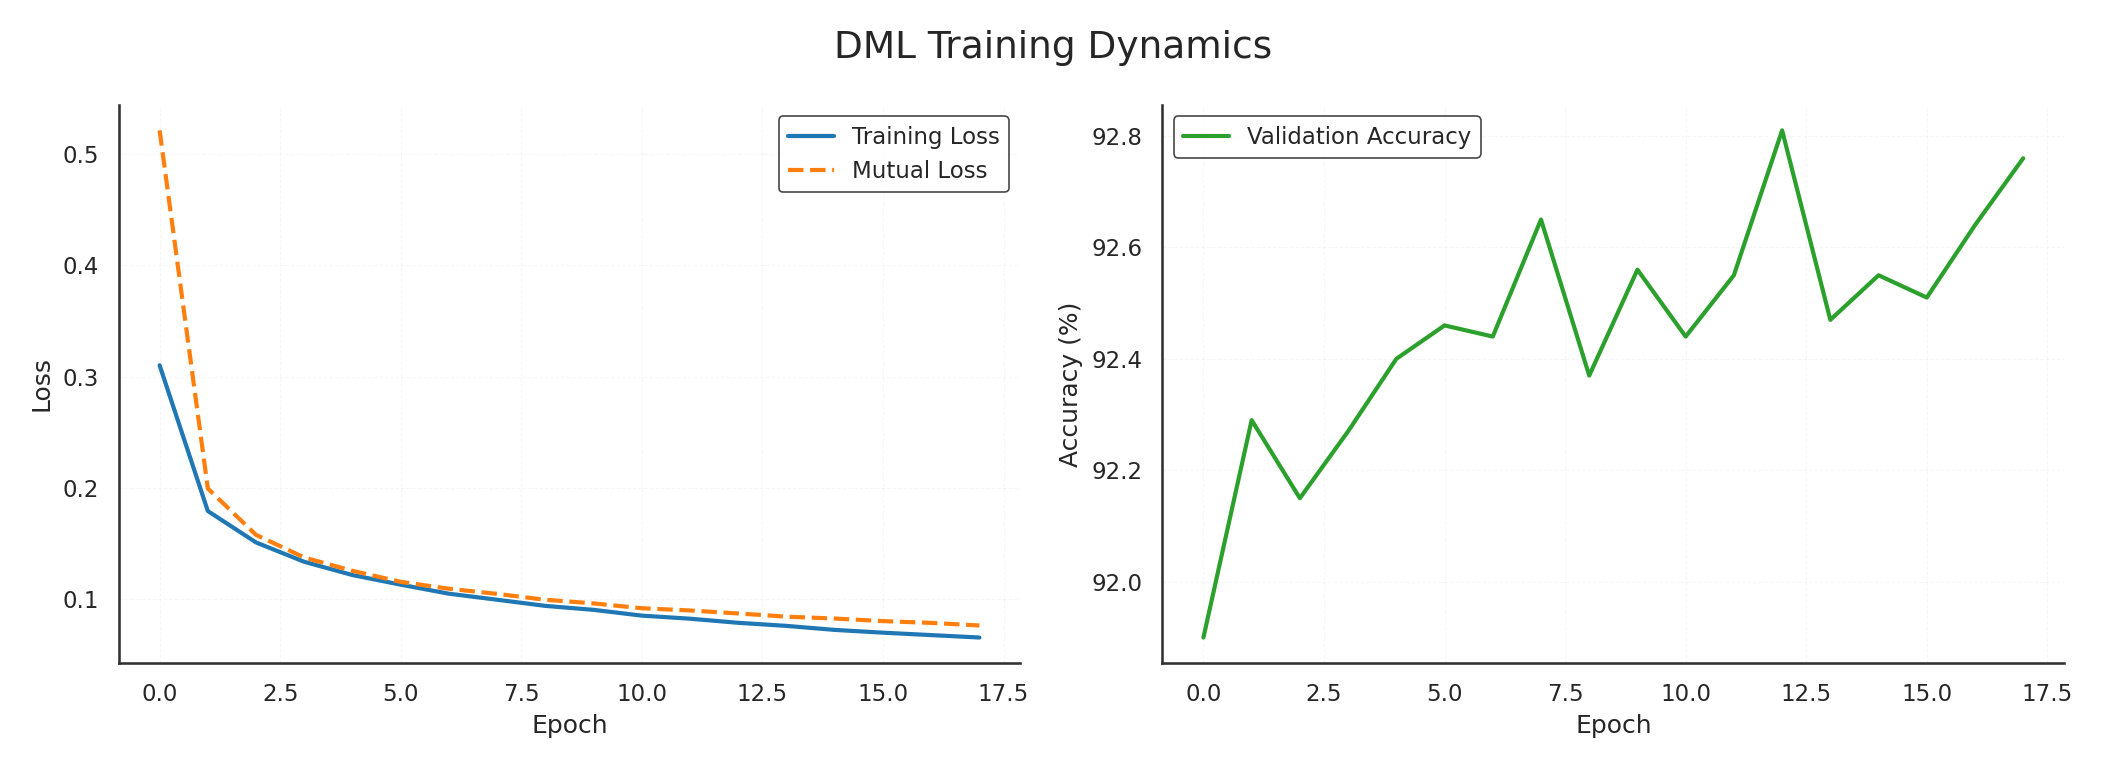

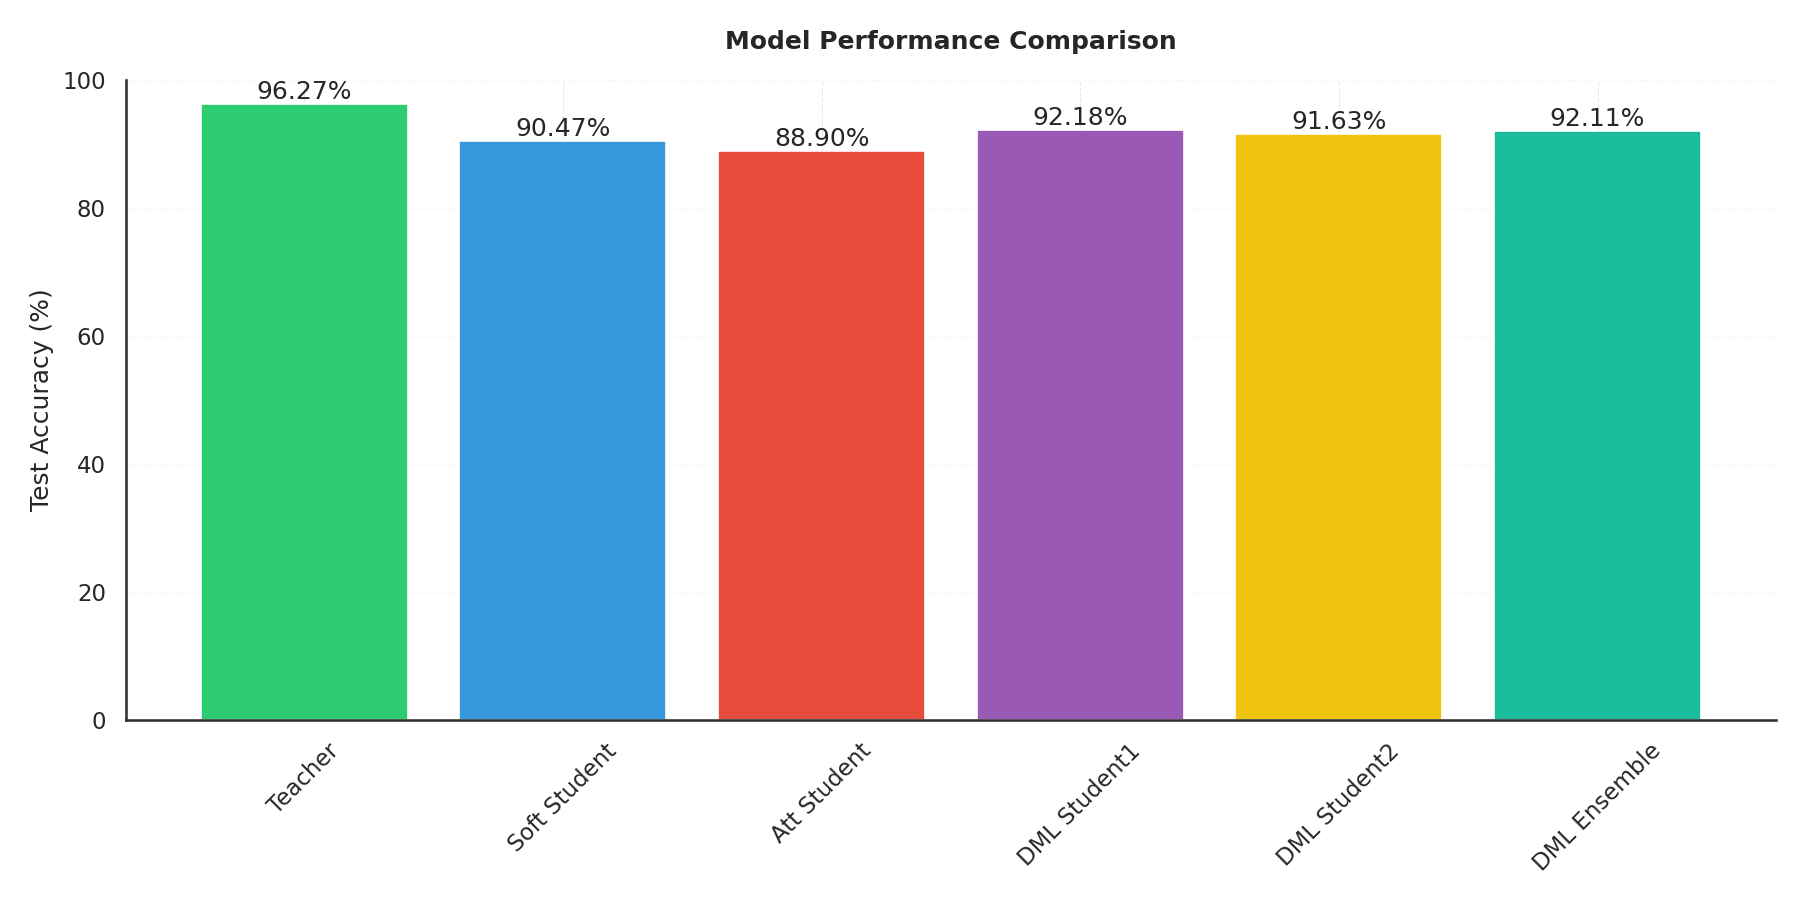

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import time

# Set random seeds
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

def set_style():
    """Custom styling for all plots with enhanced settings"""
    sns.set_style("whitegrid", {
        'axes.edgecolor': '0.2',
        'axes.linewidth': 0.8,
        'grid.color': '0.9',
        'grid.linestyle': '--',
        'grid.linewidth': 0.5
    })

    sns.set_palette("husl")
    plt.rcParams.update({
        # Figure
        "figure.figsize": (14, 8),
        "figure.dpi": 150,
        "figure.autolayout": True,
        "figure.titlesize": 18,

        # Font
        "font.family": "DejaVu Sans",
        "font.size": 12,
        "font.weight": "normal",

        # Axes
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "axes.titleweight": "bold",
        "axes.titlepad": 15,
        "axes.labelweight": "normal",
        "axes.spines.top": False,
        "axes.spines.right": False,

        # Ticks
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "xtick.major.size": 6,
        "ytick.major.size": 6,

        # Legend
        "legend.fontsize": 12,
        "legend.frameon": True,
        "legend.framealpha": 0.9,
        "legend.edgecolor": "0.2",

        # Lines
        "lines.linewidth": 2.5,
        "lines.markersize": 8,

        # Saving
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.2,
        "savefig.dpi": 300,
        "savefig.format": "png"
    })

    sns.set_context("notebook", rc={
        "lines.linewidth": 2.5,
        "patch.linewidth": 0.8,
        "grid.linewidth": 0.5
    })

# ====================== DML Implementation ========================
class MutualLearningTrainer:
    def __init__(self, device):
        self.device = device
        self.config = DATASET_CONFIG['cifar10']
        self.load_data()
        self.metrics = {
            'train_loss': [],
            'val_acc': [],
            'mutual_loss': [],
            'test_acc': {'model1': None, 'model2': None, 'ensemble': None}
        }

    def load_data(self):
        train_set = self.config['dataset_class'](
            root='./data', train=True, download=True,
            transform=self.config['transform'])
        test_set = self.config['dataset_class'](
            root='./data', train=False,
            transform=self.config['transform'])

        train_indices, val_indices = train_test_split(
            range(len(train_set)), test_size=0.2,
            random_state=CONFIG['seed'])

        self.train_loader = DataLoader(
            Subset(train_set, train_indices),
            batch_size=CONFIG['batch_size'],
            shuffle=True,
            num_workers=CONFIG['num_workers'])

        self.val_loader = DataLoader(
            Subset(train_set, val_indices),
            batch_size=CONFIG['batch_size'],
            shuffle=False,
            num_workers=CONFIG['num_workers'])

        self.test_loader = DataLoader(
            test_set,
            batch_size=CONFIG['batch_size'],
            shuffle=False,
            num_workers=CONFIG['num_workers'])

    def train_dml(self, beta1=0.5, beta2=0.5,
                temperature1=3, temperature2=3,
                load_pretrained=True):
        """Asymmetric Deep Mutual Learning Implementation"""
        model1 = AttentionWrapper('resnet18', self.config['num_classes'])
        model2 = AttentionWrapper('resnet18', self.config['num_classes'])

        if load_pretrained:
            # Load pretrained student models
            soft_final_path = os.path.join(CONFIG['model_dir'], 'student_soft_final_checkpoint.pth')
            checkpoint = torch.load(soft_final_path)  # Load full checkpoint
            model1.load_state_dict(checkpoint['model_state_dict'])

            attention_final_path = os.path.join(CONFIG['model_dir'], 'student_attention_final_checkpoint.pth')
            checkpoint = torch.load(attention_final_path)  # Load full checkpoint
            model2.load_state_dict(checkpoint['model_state_dict'])
            print("Loaded pretrained students")

        model1.to(self.device)
        model2.to(self.device)

        optimizer1 = optim.AdamW(model1.parameters(), lr=1e-4)
        optimizer2 = optim.AdamW(model2.parameters(), lr=1e-4)
        ce_loss = nn.CrossEntropyLoss()
        scaler = torch.cuda.amp.GradScaler(enabled=CONFIG['use_amp'])

        best_val = 0
        patience_counter = 0

        for epoch in range(CONFIG['epochs']['student']):
            model1.train()
            model2.train()
            epoch_loss = 0.0
            mutual_loss = 0.0

            for inputs, labels in tqdm(self.train_loader, desc=f'DML Epoch {epoch+1}'):
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer1.zero_grad()
                optimizer2.zero_grad()

                with torch.cuda.amp.autocast(enabled=CONFIG['use_amp']):
                    out1 = model1(inputs)
                    out2 = model2(inputs)

                    # Cross entropy losses
                    ce1 = ce_loss(out1, labels)
                    ce2 = ce_loss(out2, labels)

                    # Asymmetric KL divergence
                    kl_loss1 = F.kl_div(
                        F.log_softmax(out1/temperature1, dim=1),
                        F.softmax(out2.detach()/temperature1, dim=1),
                        reduction='batchmean') * (temperature1 ** 2)

                    kl_loss2 = F.kl_div(
                        F.log_softmax(out2/temperature2, dim=1),
                        F.softmax(out1.detach()/temperature2, dim=1),
                        reduction='batchmean') * (temperature2 ** 2)

                    # Combined loss
                    loss1 = (1 - beta1) * ce1 + beta1 * kl_loss1
                    loss2 = (1 - beta2) * ce2 + beta2 * kl_loss2
                    total_loss = (loss1 + loss2) / 2

                scaler.scale(total_loss).backward()
                scaler.step(optimizer1)
                scaler.step(optimizer2)
                scaler.update()

                epoch_loss += total_loss.item()
                mutual_loss += (kl_loss1.item() + kl_loss2.item()) / 2

            # Validation
            val_acc = self.evaluate_ensemble(self.val_loader, model1, model2)['accuracy']
            self.metrics['train_loss'].append(epoch_loss/len(self.train_loader))
            self.metrics['val_acc'].append(val_acc)
            self.metrics['mutual_loss'].append(mutual_loss/len(self.train_loader))

            # Early stopping
            if val_acc > best_val + CONFIG['early_stopping']['delta']:
                best_val = val_acc
                patience_counter = 0
                torch.save(model1.state_dict(), os.path.join(CONFIG['model_dir'], 'dml_model1_best.pth'))
                torch.save(model2.state_dict(), os.path.join(CONFIG['model_dir'], 'dml_model2_best.pth'))
            else:
                patience_counter += 1
                if patience_counter >= CONFIG['early_stopping']['patience']:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

            print(f"Epoch {epoch+1}: Loss {epoch_loss/len(self.train_loader):.4f} | Val Acc {val_acc:.2f}%")

        # Final evaluation
        self.metrics['test_acc']['model1'] = self.evaluate_model(model1, self.test_loader, self.device)
        self.metrics['test_acc']['model2'] = self.evaluate_model(model2, self.test_loader, self.device)
        self.metrics['test_acc']['ensemble'] = self.evaluate_ensemble(self.test_loader, model1, model2)

        return self.metrics

    # Replace DML's evaluate_model speed measurement with:
    def evaluate_model(self, model, loader, device):
        """Accurate speed measurement matching original implementation"""
        model.eval()
        # Measure speed SEPARATELY from accuracy
        speed = measure_inference_speed(model, loader, device)  # Use original function

        # Now measure accuracy
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return {
            'accuracy': 100 * correct / total,
            'inference_throughput': speed,
            'parameters': sum(p.numel() for p in model.parameters()) // 1e6
        }

    def evaluate_ensemble(self, loader, model1, model2):
        model1.eval()
        model2.eval()
        correct, total = 0, 0
        total_time = 0.0

        # Warmup
        with torch.no_grad():
            inputs = next(iter(loader))[0].to(self.device)
            _ = model1(inputs)
            _ = model2(inputs)

        # Measure metrics
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                start = time.time()
                out1 = F.softmax(model1(inputs), dim=1)
                out2 = F.softmax(model2(inputs), dim=1)
                combined = (out1 + out2) / 2
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                total_time += time.time() - start

                _, predicted = torch.max(combined, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return {
            'accuracy': 100 * correct / total,
            'inference_time': (total_time / len(loader)) * 1000,
            'parameters': (sum(p.numel() for p in model1.parameters()) +
                          sum(p.numel() for p in model2.parameters())) // 1e6
        }

# ================== Visualization & Metrics ===================
def plot_dml_training_curves(metrics):
    set_style()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Training curves
    ax1.plot(metrics['train_loss'], label='Training Loss', color='#1f77b4', lw=2)
    ax1.plot(metrics['mutual_loss'], label='Mutual Loss', color='#ff7f0e', ls='--', lw=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Validation accuracy
    ax2.plot(metrics['val_acc'], label='Validation Accuracy', color='#2ca02c', lw=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.suptitle('DML Training Dynamics')
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['plot_dir'], 'dml_training_curves.png'))
    plt.show()

def plot_performance_comparison():
    """Updated to directly use global METRICS"""
    models = ['Teacher', 'Soft Student', 'Att Student',
             'DML Student1', 'DML Student2', 'DML Ensemble']

    # Get metrics from global storage
    teacher_acc = METRICS['test_accuracies']['teacher']
    soft_acc = METRICS['test_accuracies']['student_soft']
    att_acc = METRICS['test_accuracies']['student_attention']

    # Get DML metrics from file
    dml_path = os.path.join(CONFIG['model_dir'], 'dml_metrics.json')
    dml_metrics = load_metrics(dml_path)  # Assume load_metrics exists

    accuracies = [
        teacher_acc*100,
        soft_acc*100,
        att_acc*100,
        dml_metrics['test_acc']['model1']['accuracy'],
        dml_metrics['test_acc']['model2']['accuracy'],
        dml_metrics['test_acc']['ensemble']['accuracy']
    ]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(models, accuracies, color=['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f1c40f', '#1abc9c'])

    plt.ylabel('Test Accuracy (%)')
    plt.title('Model Performance Comparison')
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['plot_dir'], 'dml_performance_comparison.png'))
    plt.show()

# ================== Execution Block ===================
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dml_metrics_path = os.path.join(CONFIG['model_dir'], 'dml_metrics.json')

    # Initialize trainer for potential evaluation
    dml_trainer = MutualLearningTrainer(device)

    # Always try to load existing models and evaluate
    models_loaded = False
    model1_path = os.path.join(CONFIG['model_dir'], 'dml_model1_best.pth')
    model2_path = os.path.join(CONFIG['model_dir'], 'dml_model2_best.pth')

    if os.path.exists(model1_path) and os.path.exists(model2_path):
        try:
            # Load models
            model1 = AttentionWrapper('resnet18', DATASET_CONFIG['cifar10']['num_classes'])
            model2 = AttentionWrapper('resnet18', DATASET_CONFIG['cifar10']['num_classes'])

            model1.load_state_dict(torch.load(model1_path))
            model2.load_state_dict(torch.load(model2_path))

            model1.to(device).eval()
            model2.to(device).eval()
            models_loaded = True
            print("Loaded pretrained DML models successfully")
        except Exception as e:
            print(f"Error loading models: {str(e)}")
            models_loaded = False

    # Run training if metrics don't exist
    if not os.path.exists(dml_metrics_path) or not models_loaded:
        print("Starting DML training...")
        dml_metrics = dml_trainer.train_dml(
            beta1=0.6, beta2=0.4,
            temperature1=2, temperature2=3,
            load_pretrained=True
        )

        # Save metrics
        DML_METRICS = {
            'test_acc': dml_metrics['test_acc'],
            'training_curves': {
                'train_loss': dml_metrics['train_loss'],
                'val_acc': dml_metrics['val_acc'],
                'mutual_loss': dml_metrics['mutual_loss']
            }
        }
        save_metrics(DML_METRICS, dml_metrics_path)
    else:
        # Re-evaluate test performance with loaded models
        print("Re-evaluating test performance...")
        DML_METRICS = load_metrics(dml_metrics_path)

        # Get fresh evaluation results
        test_acc_model1 = dml_trainer.evaluate_model(model1, dml_trainer.test_loader, device)
        test_acc_model2 = dml_trainer.evaluate_model(model2, dml_trainer.test_loader, device)
        test_acc_ensemble = dml_trainer.evaluate_ensemble(dml_trainer.test_loader, model1, model2)

        # Update metrics with fresh evaluation
        DML_METRICS['test_acc'] = {
            'model1': test_acc_model1,
            'model2': test_acc_model2,
            'ensemble': test_acc_ensemble
        }

        # Save updated metrics
        save_metrics(DML_METRICS, dml_metrics_path)

    # Load final metrics for plotting
    try:
        dml_metrics = load_metrics(dml_metrics_path)
        assert dml_metrics is not None, "Loaded empty DML metrics"
    except Exception as e:
        raise RuntimeError(f"Failed to load DML metrics: {str(e)}")

    # Generate plots with validation
    plot_dml_training_curves(dml_metrics['training_curves'])
    plot_performance_comparison()

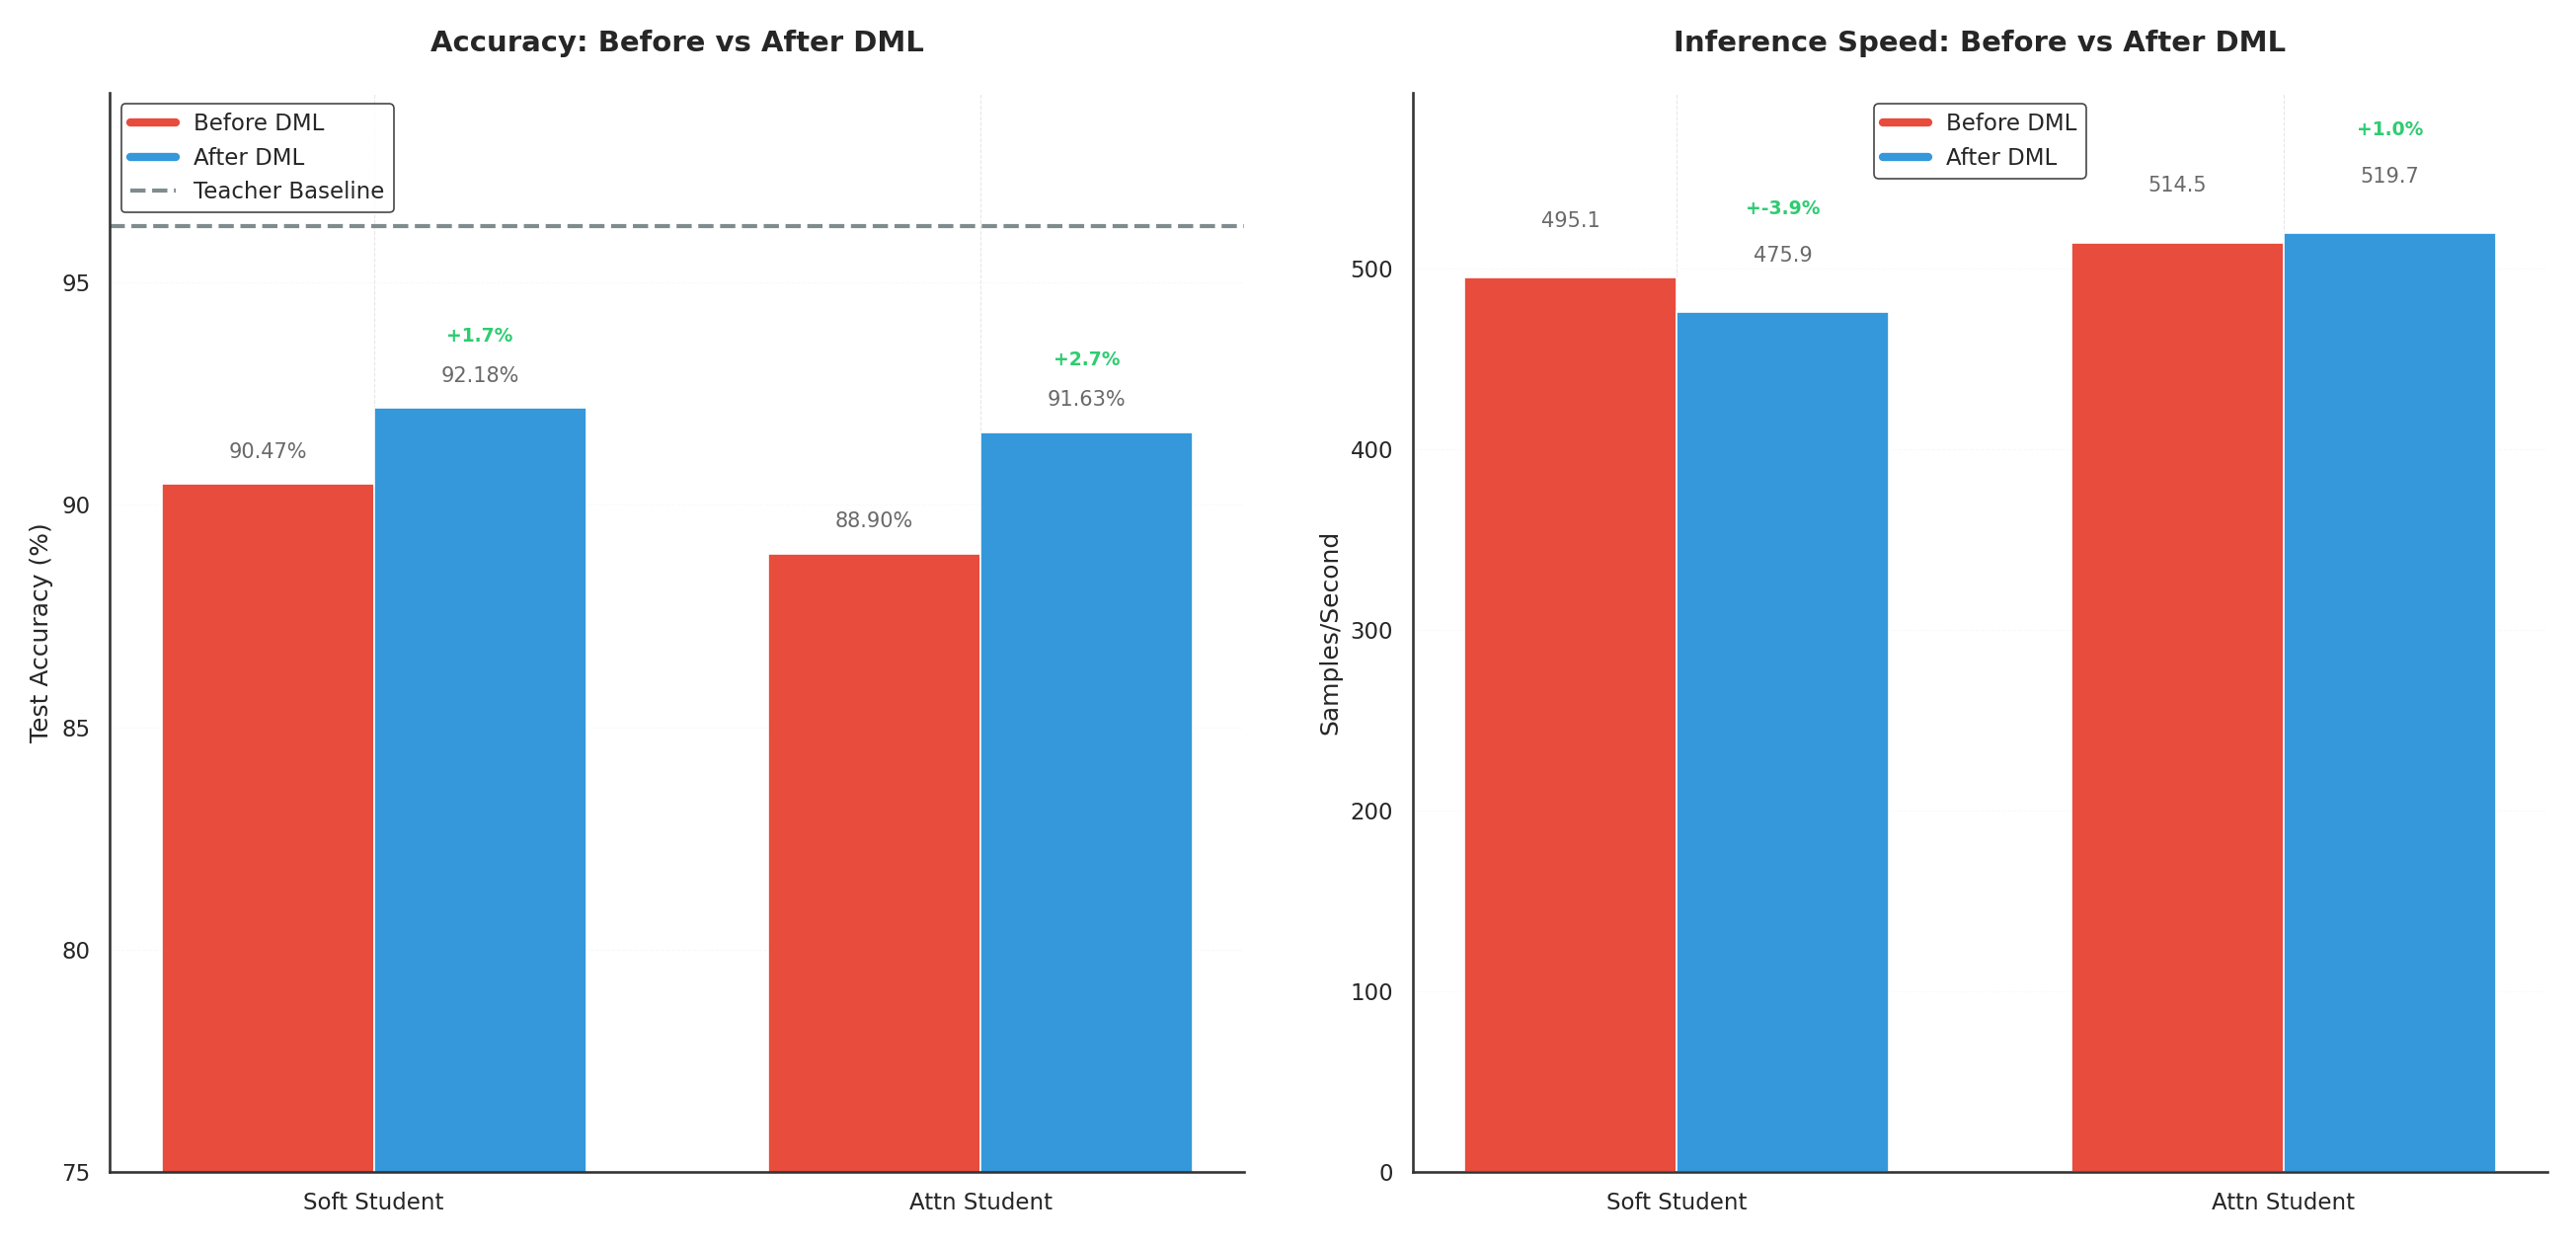

In [ ]:
# Set random seeds
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
def plot_dml_comparison():
    set_style()
    plt.figure(figsize=(18, 9))

    # Modern color scheme
    palette = {
        'teacher': '#7f8c8d',    # Neutral gray
        'before': '#e74c3c',     # Red
        'after': '#3498db',      # Blue
        'improvement': '#2ecc71' # Green for delta
    }

    # Load metrics
    dml_path = os.path.join(CONFIG['model_dir'], 'dml_metrics.json')
    dml_metrics = load_metrics(dml_path)

    # Data organization
    comparison_groups = {
        'Soft Student': {
            'before': METRICS['test_accuracies']['student_soft'] * 100,
            'after': dml_metrics['test_acc']['model1']['accuracy'],
            'speed_before': METRICS['inference_speed']['student_soft'],
            'speed_after': dml_metrics['test_acc']['model1']['inference_throughput']
        },
        'Attn Student': {
            'before': METRICS['test_accuracies']['student_attention'] * 100,
            'after': dml_metrics['test_acc']['model2']['accuracy'],
            'speed_before': METRICS['inference_speed']['student_attention'],
            'speed_after': dml_metrics['test_acc']['model2']['inference_throughput']
        }
    }

    # ===== Accuracy Comparison =====
    plt.subplot(1, 2, 1)

    # Teacher baseline
    teacher_acc = METRICS['test_accuracies']['teacher'] * 100
    plt.axhline(teacher_acc, color=palette['teacher'], linestyle='--',
                label='Teacher Baseline', linewidth=2)

    # Plot comparison bars
    bar_width = 0.35
    for idx, (label, metrics) in enumerate(comparison_groups.items()):
        positions = [idx - bar_width/2, idx + bar_width/2]
        bars = plt.bar(positions, [metrics['before'], metrics['after']],
                width=bar_width, color=[palette['before'], palette['after']])

        # Add values on top of bars
        for pos, value in zip(positions, [metrics['before'], metrics['after']]):
            plt.text(pos, value + 0.5, f'{value:.2f}%',
                     ha='center', va='bottom', fontsize=10, color='dimgray')

        # Add improvement arrows
        improvement = metrics['after'] - metrics['before']
        plt.annotate(f'+{improvement:.1f}%',
                    xy=(positions[1], metrics['after'] + 1.5),
                    ha='center', color=palette['improvement'],
                    fontweight='bold', fontsize=9)

    plt.xticks(range(len(comparison_groups)), comparison_groups.keys())
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title('Accuracy: Before vs After DML', fontsize=14, pad=20)
    plt.ylim(75, max([teacher_acc, *[m['after'] for m in comparison_groups.values()]]) + 3)
    plt.grid(axis='y', alpha=0.2)

    # Create custom legend
    legend_elements = [
        plt.Line2D([0], [0], color=palette['before'], lw=4, label='Before DML'),
        plt.Line2D([0], [0], color=palette['after'], lw=4, label='After DML'),
        plt.Line2D([0], [0], color=palette['teacher'], linestyle='--',
                  lw=2, label='Teacher Baseline')
    ]
    plt.legend(handles=legend_elements, loc='upper left')

    # ===== Inference Speed Comparison =====
    plt.subplot(1, 2, 2)

    # Calculate dynamic positioning
    max_speed = max([m['speed_after'] for m in comparison_groups.values()])
    value_offset = max_speed * 0.05
    speedup_offset = max_speed * 0.10

    for idx, (label, metrics) in enumerate(comparison_groups.items()):
        positions = [idx - bar_width/2, idx + bar_width/2]
        bars = plt.bar(positions, [metrics['speed_before'], metrics['speed_after']],
                      width=bar_width, color=[palette['before'], palette['after']])

        # Add values on top of bars
        for pos, value in zip(positions, [metrics['speed_before'], metrics['speed_after']]):
            plt.text(pos, value + value_offset, f'{value:.1f}',
                    ha='center', va='bottom', fontsize=10, color='dimgray')

        # Add speedup percentages
        speedup = ((metrics['speed_after'] - metrics['speed_before'])/metrics['speed_before'])*100
        plt.text(positions[1], metrics['speed_after'] + speedup_offset,
                f'+{speedup:.1f}%', ha='center',
                color=palette['improvement'], fontweight='bold', fontsize=9,
                va='bottom')

    # Axis labels and formatting
    plt.xticks(range(len(comparison_groups)), comparison_groups.keys())
    plt.ylabel('Samples/Second', fontsize=12)
    plt.title('Inference Speed: Before vs After DML', fontsize=14, pad=20)
    plt.ylim(0, max_speed + speedup_offset * 1.5)
    plt.grid(axis='y', alpha=0.2)

    # Add legend for speed plot
    plt.legend(handles=[
        plt.Line2D([0], [0], color=palette['before'], lw=4, label='Before DML'),
        plt.Line2D([0], [0], color=palette['after'], lw=4, label='After DML')
    ], loc='upper center')

    # Final layout adjustments
    plt.tight_layout(pad=3.0)
    plt.savefig(os.path.join(CONFIG['plot_dir'], 'dml_comparison.png'), dpi=300)
    plt.show()

plot_dml_comparison()

In [ ]:
def load_teacher():
    teacher = AttentionWrapper('resnet50', num_classes=10)
    teacher.load_state_dict(torch.load(os.path.join(CONFIG['model_dir'], 'teacher_best.pth')))
    return teacher.to(device)

def load_student(student_type):
    model = AttentionWrapper('resnet18', num_classes=10)
    if student_type == 'soft':
        path = os.path.join(CONFIG['model_dir'], 'student_soft_final_checkpoint.pth')
    else:
        path = os.path.join(CONFIG['model_dir'], 'student_attention_final_checkpoint.pth')
    model.load_state_dict(torch.load(path)['model_state_dict'])
    return model.to(device)

def load_dml_model(model_num):
    model = AttentionWrapper('resnet18', num_classes=10)
    path = os.path.join(CONFIG['model_dir'], f'dml_model{model_num}_best.pth')
    model.load_state_dict(torch.load(path))
    return model.to(device)

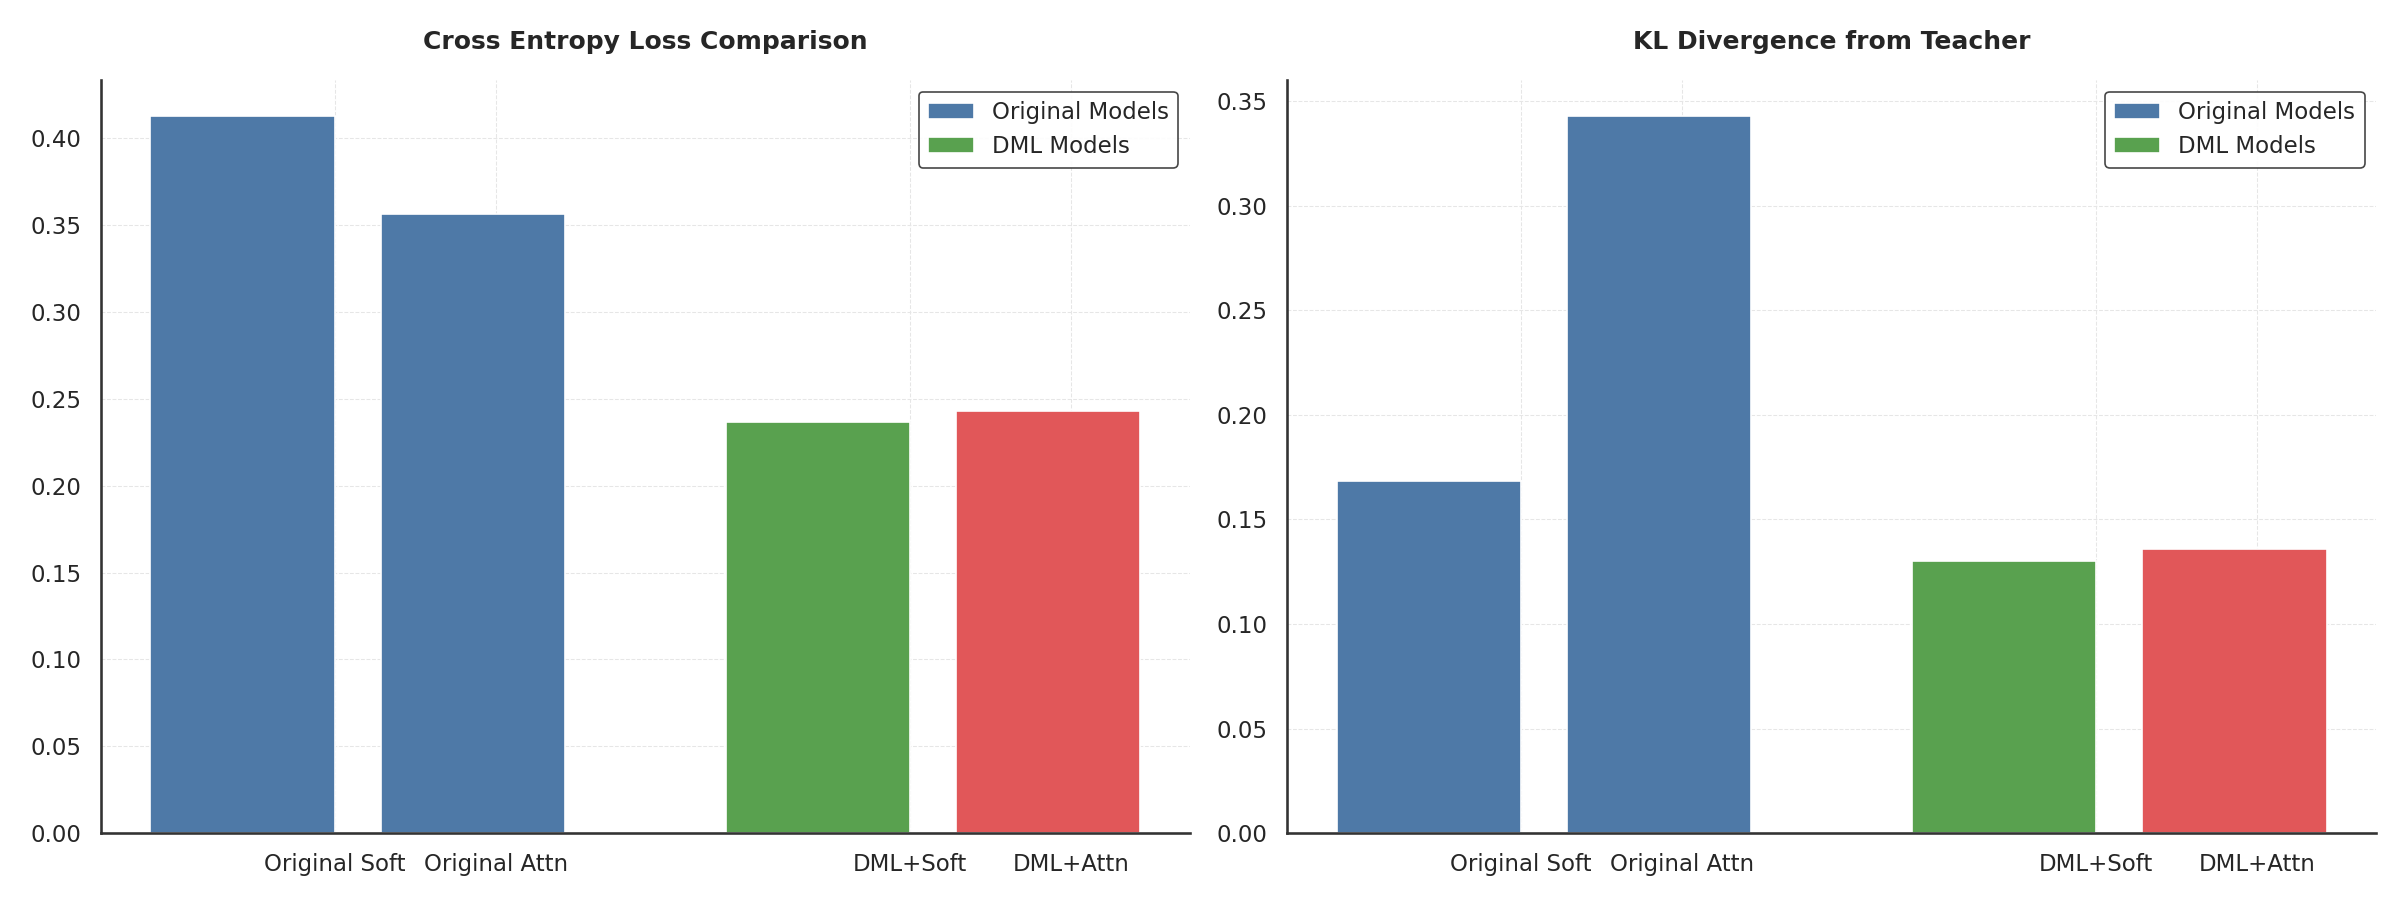

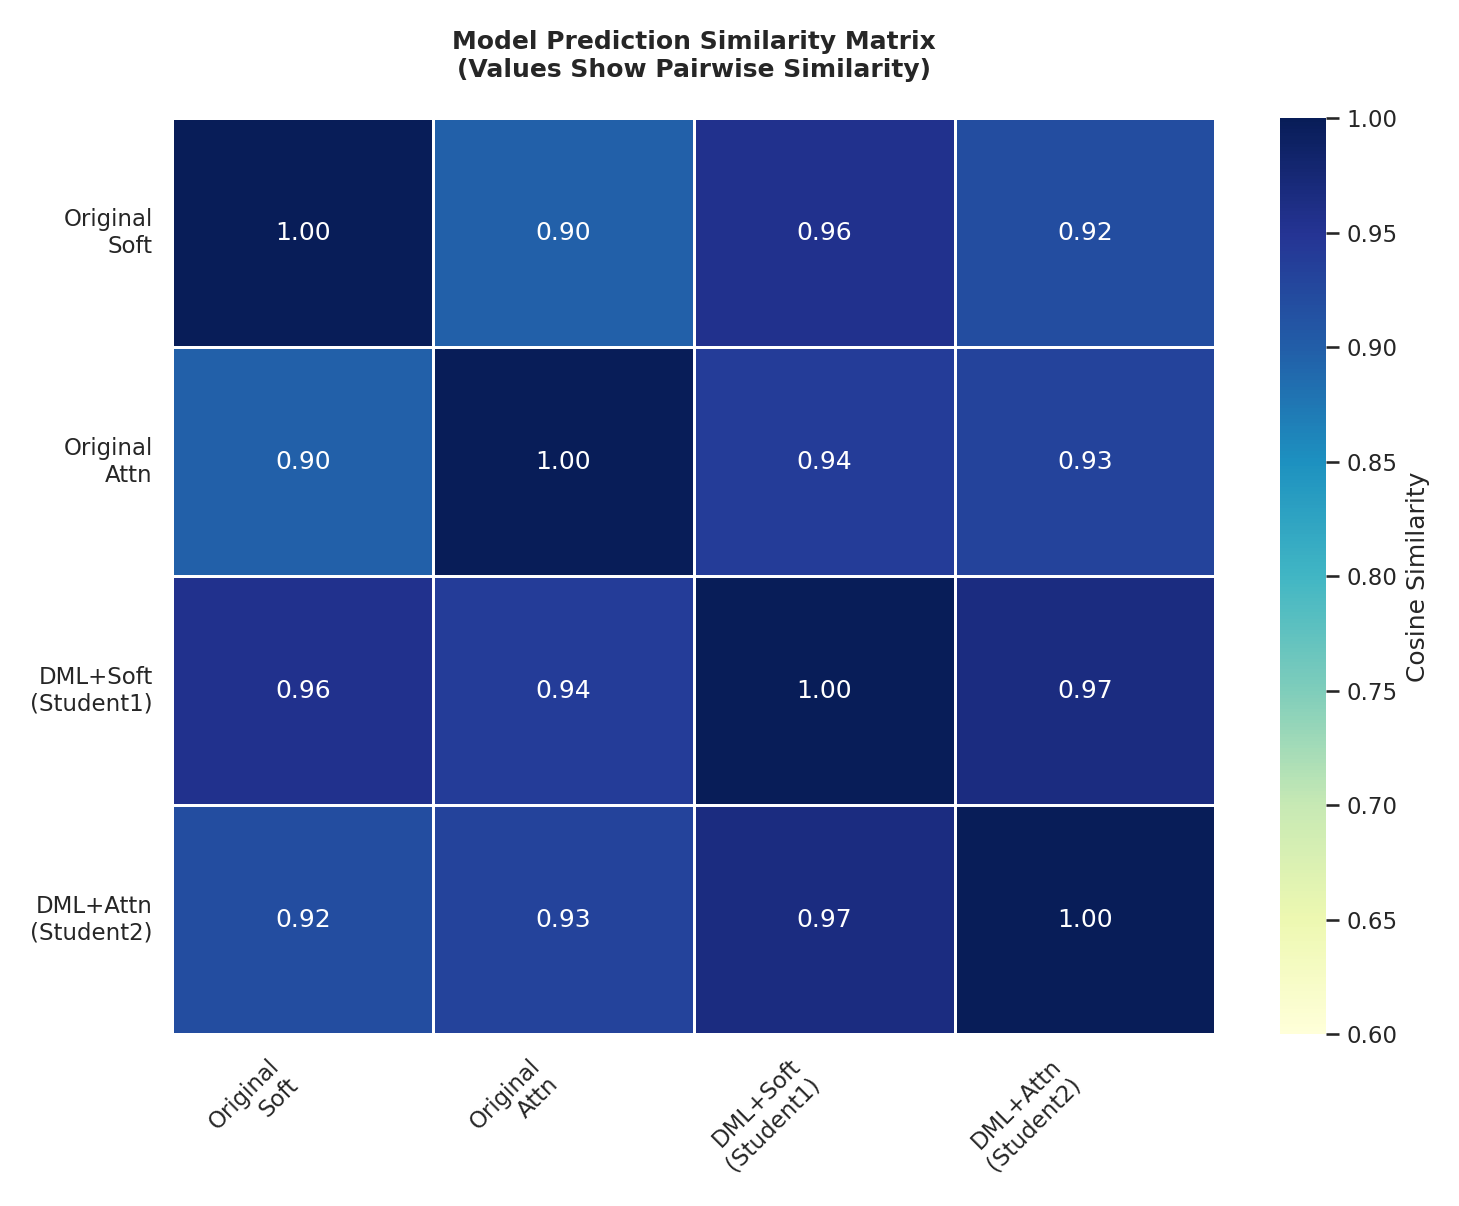

In [ ]:
# Add to imports at the top
import os
import torch
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

def get_predictions(model, loader):
    """Helper function to collect model predictions"""
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs)
    return torch.cat(all_outputs, dim=0)

def plot_loss_comparison(original_metrics, dml_metrics, test_loader):
    """Compare key losses before and after DML with group comparisons"""

    def calculate_losses(model, loader, teacher=None):
        model.eval()
        ce_loss = nn.CrossEntropyLoss()
        kl_loss = nn.KLDivLoss(reduction='batchmean')
        total_ce, total_kl = 0, 0

        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                total_ce += ce_loss(outputs, labels).item()
                if teacher:
                    with torch.no_grad():
                        teacher_logits = teacher(inputs)
                    total_kl += kl_loss(
                        F.log_softmax(outputs/3, dim=1),
                        F.softmax(teacher_logits/3, dim=1)
                    ).item()

        return {
            'CE': total_ce/len(loader),
            'KL': total_kl/len(loader) if teacher else None
        }

    teacher = load_teacher()
    models = {
        'Original Soft': load_student('soft'),
        'Original Attn': load_student('attention'),
        'DML+Soft': load_dml_model(1),
        'DML+Attn': load_dml_model(2)
    }

    metrics = {name: calculate_losses(model, test_loader, teacher)
              for name, model in models.items()}

    # Plotting setup with consistent colors for original models
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    colors = {
        'Original Soft': '#4e79a7',
        'Original Attn': '#4e79a7',  # Same color for both originals
        'DML+Soft': '#59a14f',
        'DML+Attn': '#e15759'
    }

    # Cross Entropy plot
    for idx, (group_name, model_names) in enumerate([
        ('Original Models', ['Original Soft', 'Original Attn']),
        ('DML Models', ['DML+Soft', 'DML+Attn'])
    ]):
        x = idx * 2.5 + np.arange(len(model_names))
        ax1.bar(x, [metrics[n]['CE'] for n in model_names],
               color=[colors[n] for n in model_names],
               width=0.8, label=group_name)

    ax1.set_xticks([0.4, 1.1, 2.9, 3.6])
    ax1.set_xticklabels(models.keys())
    ax1.set_title('Cross Entropy Loss Comparison')
    ax1.legend()

    # KL Divergence plot
    for idx, (group_name, model_names) in enumerate([
        ('Original Models', ['Original Soft', 'Original Attn']),
        ('DML Models', ['DML+Soft', 'DML+Attn'])
    ]):
        x = idx * 2.5 + np.arange(len(model_names))
        ax2.bar(x, [metrics[n]['KL'] for n in model_names],
               color=[colors[n] for n in model_names],
               width=0.8, label=group_name)

    ax2.set_xticks([0.4, 1.1, 2.9, 3.6])
    ax2.set_xticklabels(models.keys())
    ax2.set_title('KL Divergence from Teacher')
    ax2.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['plot_dir'], 'loss_comparison.png'))
    plt.show()

def plot_similarity_analysis(original_metrics, dml_metrics, test_loader):
    """Enhanced similarity comparison with matrix format"""
    models = {
        'Original\nSoft': load_student('soft'),
        'Original\nAttn': load_student('attention'),
        'DML+Soft\n(Student1)': load_dml_model(1),
        'DML+Attn\n(Student2)': load_dml_model(2)
    }

    preds = {name: get_predictions(model, test_loader)
            for name, model in models.items()}

    # Create full matrix comparison
    model_names = list(models.keys())
    similarity_matrix = np.eye(len(model_names))

    for i, j in itertools.combinations(range(len(model_names)), 2):
        sim = F.cosine_similarity(preds[model_names[i]], preds[model_names[j]]).mean().item()
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim

    # Create annotated dataframe
    df = pd.DataFrame(similarity_matrix,
                     index=model_names,
                     columns=model_names)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='YlGnBu',
                vmin=0.6, vmax=1.0, fmt=".2f",
                linewidths=0.5, cbar_kws={'label': 'Cosine Similarity'})

    plt.title('Model Prediction Similarity Matrix\n(Values Show Pairwise Similarity)', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['plot_dir'], 'enhanced_similarity_matrix.png'))
    plt.show()

# ================== Execution Block ===================
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dml_metrics_path = os.path.join(CONFIG['model_dir'], 'dml_metrics.json')

    # Load test dataset
    config = DATASET_CONFIG['cifar10']
    test_set = config['dataset_class'](root='./data', train=False,
                                      transform=config['transform'])
    test_loader = DataLoader(test_set, batch_size=CONFIG['batch_size'], shuffle=False)

    # Load/create metrics
    if os.path.exists(dml_metrics_path):
        dml_metrics = load_metrics(dml_metrics_path)
    else:
        dml_trainer = MutualLearningTrainer(device)
        dml_metrics = dml_trainer.train_dml(
            beta1=0.6, beta2=0.4,
            temperature1=2, temperature2=3,
            load_pretrained=True
        )
        save_metrics(dml_metrics, dml_metrics_path)

    # Generate plots
    plot_loss_comparison(METRICS, dml_metrics, test_loader)
    plot_similarity_analysis(METRICS, dml_metrics, test_loader)